# Deep learning with H2O

## H2O Python module

Load the H2O libraries.

In [2]:
import h2o

## Start H2O

Start up a 1-node H2O cloud on your local machine, and allow it to use all CPU cores and up to 8GB of memory. It is a good idea to check the startup stats.

In [3]:
h2o.init(min_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/jamespearce/miniconda3/envs/dl/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmph43uhdwg
  JVM stdout: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmph43uhdwg/h2o_jamespearce_started_from_python.out
  JVM stderr: /var/folders/53/ywlydrqn0dn1x3lz3_c3j0jr0000gn/T/tmph43uhdwg/h2o_jamespearce_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Australia/Melbourne
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 14 days
H2O cluster name:,H2O_from_python_jamespearce_dbeem1
H2O cluster total nodes:,1
H2O cluster free memory:,7.667 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [4]:
h2o.remove_all()  # clean up just in case anything was already there if the cluster was already running.

# H2O deep learning

H2O's deep learning was designed to be easy to use, like H2O's other supervised training methods that you saw before. Indeed `H2OAutoML` includes deep learning algorithmsif you let it run long enough.

Features of H2O deep learning include

  * early stopping
  * automatic data standardization
  * automatic handling of categorical variables
  * automatic handling of missing values
  * adaptive learning weights
  
Users still need to specify

  * number of hidden layers
  * size of hidden layers
  * number of epochs 
  * regularization techniques
  
_unless_, of course, you just use `H2OAutoML` for an intelligent search of the parameter space.

## Toy example #1 – decision boundaries

We start with a small dataset representing red and black dots on a plane, arranged in the shape of two nested spirals. Then we task H2O's machine learning methods to separate the red and black dots, i.e., recognize each spiral as such by assigning each point in the plane to one of the two spirals.

We visualize the nature of H2O Deep Learning (DL), H2O's tree methods (GBM/DRF) and H2O's generalized linear modeling (GLM) by plotting the decision boundary between the red and black spirals:

Let's get our imports first.

In [6]:
%matplotlib inline  

#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

First, we need to upload our datasets to the the H2O cluster. The data is imported into H2OFrames, which operate similarly in function to pandas DataFrames.

In this case, the cluster is running on the DSVM. You will need to update the locations to the paths on your DSVM.

In [8]:
import os
spiral = h2o.import_file(path = os.path.realpath("../data/spiral.csv"))
grid  = h2o.import_file(path = os.path.realpath("../data/grid.csv"))

/Users/jamespearce/repos/dl/notebooks
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


**Spiral** is a simple data set consisting of two spirals of black and red dots.  
**Grid** is a 201 by 201 matrix with dimensions [-1.5, 1.5] by [-1.5, 1.5].

To visualize these datasets, we can pull them from H2OFrames into pandas DataFrames for easier plotting.

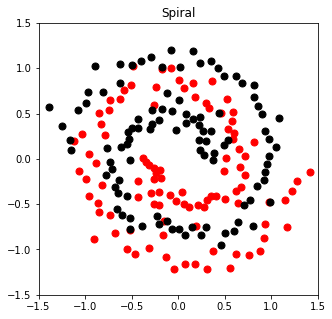

In [9]:
spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.values.reshape(201,201), grid_df.y.values.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]

spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]
spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]
    
markersize_ = 7**2
plt.figure(figsize = (5,5))
plt.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
plt.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title("Spiral");

## Model Construction

H2O in Python is designed to be very similar in look and feel to to `scikit-learn`. Models are initialized individually with desired or default parameters and then trained on data.

Note that the below examples use `model.train()`, as opposed the usual `scikit-learn` `model.fit()`. This is because `h2o-py` takes the data frame _and_ column indices for the feature and response columns, while `scikit-learn` takes in feature frames.

H2O supports `model.fit()` so that it can be incorporated into a `scikit-learn` pipeline, but H2O advise using `train()` in all other cases.

### Deep learning

Set up the predictors and labels.

In [12]:
predictors = spiral.col_names[0:2]
label = spiral.col_names[2]

Train the model with 1,000 epochs. First you initialize the model with the `H2ODeepLearningEstimator`, then use `model.train()`.

**Note:** here you are using deep learning without any additional inputs.

In [14]:
epochs = 1000

dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(predictors, label, spiral)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


### Other classifiers

Now fit some alternative tree-based and regression classifiers.

In [16]:
gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(predictors, label, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(predictors, label, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.train(predictors, label, spiral)               

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


### Compare classifiers

Collect the models together in a list.

In [17]:
models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted Method", "Distributed Random Forest", "Generalized Linear Model"]

Now that you've trained four models to classify points as red or black based on their (x,y) coordinates.
To see how our models have performed, you can use them to predict the colors of the grid.

Since we'll be doing a lot of spiral plotting, write a helper function to keep things clean.

In [18]:
def plot_spirals(models, model_names):
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    for k, subplot in enumerate(ax.flatten()):
        subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
        subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
        subplot.axis([-1.5, 1.5, -1.5, 1.5])
        subplot.set_title(model_names[k])
        subplot.set_xlabel('x')
        subplot.set_ylabel('y')
        pred_z = models[k].predict(grid).as_data_frame(True)
        subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).values.reshape(201,201), 
                        colors='b')

Plot graphs of each of the four contour plots of the predictions, so you can see how exactly the algorithms grouped the points into black and red.

deeplearning prediction progress: |███████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


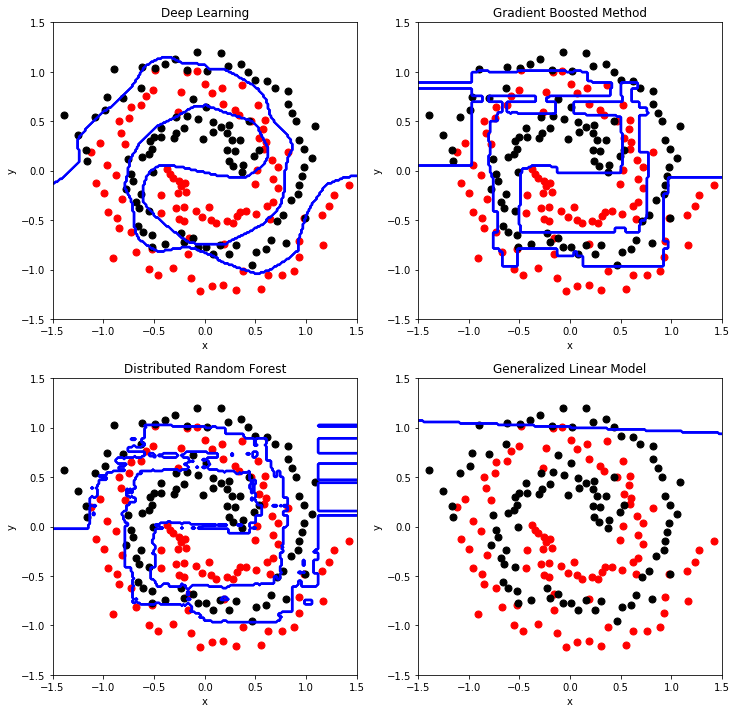

In [19]:
plot_spirals(models, m_names)

## A Deeper Dive into Deep Learning

Explore the evolution of your deep learning model over training time (number of passes over the data, known as _epochs_).

Use the `checkpoint=` argument to ensure you continue training the same model.

In [25]:
dl_1 =  H2ODeepLearningEstimator(epochs=1)
dl_1.train(predictors, label, spiral)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [26]:
dl_250 = H2ODeepLearningEstimator(checkpoint=dl_1, epochs=250)
dl_250.train(predictors, label, spiral)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1533623788278_239


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.49764957717620895
RMSE: 0.7054428234635384
LogLoss: 5.4573152449019195
Mean Per-Class Error: 0.375
AUC: 0.6351
Gini: 0.2702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.260990994370495e-09: 


,Black,Red,Error,Rate
Black,14.0,86.0,0.86,(86.0/100.0)
Red,1.0,99.0,0.01,(1.0/100.0)
Total,15.0,185.0,0.435,(87.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0000000,0.6947368,184.0
max f2,0.0000000,0.8461538,184.0
max f0point5,0.0000018,0.625,118.0
max accuracy,0.0000018,0.625,118.0
max precision,0.0357143,1.0,0.0
max recall,0.0000000,1.0,194.0
max specificity,0.0357143,1.0,0.0
max absolute_mcc,0.0000018,0.2546385,118.0
max min_per_class_accuracy,0.0000073,0.61,98.0
max mean_per_class_accuracy,0.0000018,0.625,118.0


Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.0311885,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,0.0197653,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,0.0176161,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.0079209,2.0,2.0,1.0,1.0,0.02,0.08,100.0,100.0
,5,0.05,0.0069487,2.0,2.0,1.0,1.0,0.02,0.1,100.0,100.0
,6,0.1,0.0023615,0.8,1.4,0.4,0.7,0.04,0.14,-20.0000000,40.0000000
,7,0.15,0.0008764,1.0,1.2666667,0.5,0.6333333,0.05,0.19,0.0,26.6666667
,8,0.2,0.0004044,1.0,1.2,0.5,0.6,0.05,0.24,0.0,20.0000000
,9,0.3,0.0001079,1.3,1.2333333,0.65,0.6166667,0.13,0.37,30.0000000,23.3333333
,10,0.4,0.0000241,1.4,1.275,0.7,0.6375,0.14,0.51,40.0000000,27.5000000



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-07 20:01:52,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-08-07 20:01:52,0.104 sec,666 obs/sec,0.08,1,16.0,0.7071067,8.7197378,0.6094000,2.0,0.44
,2018-08-07 20:01:52,0.226 sec,1537 obs/sec,1.015,12,203.0,0.7054428,5.4573152,0.6351,2.0,0.435


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
y,1.0,1.0,0.5128721
x,0.9498040,0.9498040,0.4871279


deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [27]:
dl_500 = H2ODeepLearningEstimator(checkpoint=dl_250, epochs=500)
dl_500.train(predictors, label, spiral)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1533623788278_242


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20975796422538578
RMSE: 0.4579934106790029
LogLoss: 0.6929474916610462
Mean Per-Class Error: 0.19999999999999996
AUC: 0.8723000000000001
Gini: 0.7446000000000002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8550649498036108: 


,Black,Red,Error,Rate
Black,78.0,22.0,0.22,(22.0/100.0)
Red,18.0,82.0,0.18,(18.0/100.0)
Total,96.0,104.0,0.2,(40.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8550649,0.8039216,103.0
max f2,0.5525322,0.8850365,147.0
max f0point5,0.9456454,0.8252427,77.0
max accuracy,0.8915504,0.8,95.0
max precision,0.9999996,1.0,0.0
max recall,0.2177717,1.0,167.0
max specificity,0.9999996,1.0,0.0
max absolute_mcc,0.8915504,0.6004806,95.0
max min_per_class_accuracy,0.8796021,0.79,99.0
max mean_per_class_accuracy,0.8915504,0.8,95.0


Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9998048,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,0.9997719,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,0.9997216,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.9996174,1.0,1.75,0.5,0.875,0.01,0.07,0.0,75.0
,5,0.05,0.9993827,2.0,1.8,1.0,0.9,0.02,0.09,100.0,80.0
,6,0.1,0.9976605,1.8,1.8,0.9,0.9,0.09,0.18,80.0,80.0
,7,0.15,0.9963495,2.0,1.8666667,1.0,0.9333333,0.1,0.28,100.0,86.6666667
,8,0.2,0.9924948,1.8,1.85,0.9,0.925,0.09,0.37,80.0,85.0000000
,9,0.3,0.9769497,1.8,1.8333333,0.9,0.9166667,0.18,0.55,80.0,83.3333333
,10,0.4,0.9407301,1.3,1.7,0.65,0.85,0.13,0.68,30.0000000,70.0



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-07 20:01:57,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-08-07 20:01:58,0.653 sec,3407 obs/sec,10.0,1,2000.0,0.6893822,2.5108393,0.6424,2.0,0.44
,2018-08-07 20:02:03,5.814 sec,4533 obs/sec,130.0,13,26000.0,0.5718637,1.4326255,0.645,2.0,0.395
,2018-08-07 20:02:07,10.116 sec,4986 obs/sec,250.0,25,50000.0,0.4579934,0.6929475,0.8723000,2.0,0.2


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
y,1.0,1.0,0.5667140
x,0.7645584,0.7645584,0.4332860


deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [28]:
dl_750 = H2ODeepLearningEstimator(checkpoint=dl_500, epochs=750)
dl_750.train(predictors, label, spiral)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1533623788278_246


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.12413148637772675
RMSE: 0.3523229858776273
LogLoss: 0.48789821895232754
Mean Per-Class Error: 0.135
AUC: 0.9434
Gini: 0.8868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6792392847791386: 


,Black,Red,Error,Rate
Black,81.0,19.0,0.19,(19.0/100.0)
Red,8.0,92.0,0.08,(8.0/100.0)
Total,89.0,111.0,0.135,(27.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6792393,0.8720379,108.0
max f2,0.4371902,0.9280303,125.0
max f0point5,0.9846090,0.8809524,77.0
max accuracy,0.7541294,0.865,104.0
max precision,1.0000000,1.0,0.0
max recall,0.0379969,1.0,147.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.6792393,0.7344570,108.0
max min_per_class_accuracy,0.9145448,0.84,96.0
max mean_per_class_accuracy,0.7541294,0.865,104.0


Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,1.0000000,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,0.9999998,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,0.9999996,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.9999992,2.0,2.0,1.0,1.0,0.02,0.08,100.0,100.0
,5,0.05,0.9999983,2.0,2.0,1.0,1.0,0.02,0.1,100.0,100.0
,6,0.1,0.9999906,2.0,2.0,1.0,1.0,0.1,0.2,100.0,100.0
,7,0.15,0.9999468,2.0,2.0,1.0,1.0,0.1,0.3,100.0,100.0
,8,0.2,0.9998089,2.0,2.0,1.0,1.0,0.1,0.4,100.0,100.0
,9,0.3,0.9979175,1.9,1.9666667,0.95,0.9833333,0.19,0.59,90.0000000,96.6666667
,10,0.4,0.9843155,1.5,1.85,0.75,0.925,0.15,0.74,50.0,85.0000000



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-07 20:02:18,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-08-07 20:02:19,0.874 sec,2484 obs/sec,10.0,1,2000.0,0.5526366,1.0436364,0.6384000,2.0,0.445
,2018-08-07 20:02:24,5.880 sec,3794 obs/sec,110.0,11,22000.0,0.6867655,2.5371256,0.4771,2.0,0.5
,2018-08-07 20:02:29,10.916 sec,4804 obs/sec,260.0,26,52000.0,0.3987920,0.5662261,0.9048,2.0,0.18
,2018-08-07 20:02:34,16.124 sec,4994 obs/sec,400.0,40,80000.0,0.3845066,0.5775567,0.9199000,2.0,0.15
,2018-08-07 20:02:37,18.853 sec,5337 obs/sec,500.0,50,100000.0,0.3523230,0.4878982,0.9434,2.0,0.135


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
y,1.0,1.0,0.5369769
x,0.8622774,0.8622774,0.4630231


deeplearning Model Build progress: |██████████████████████████████████████| 100%


You can see how the network learns the structure of the spirals with enough training time.

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


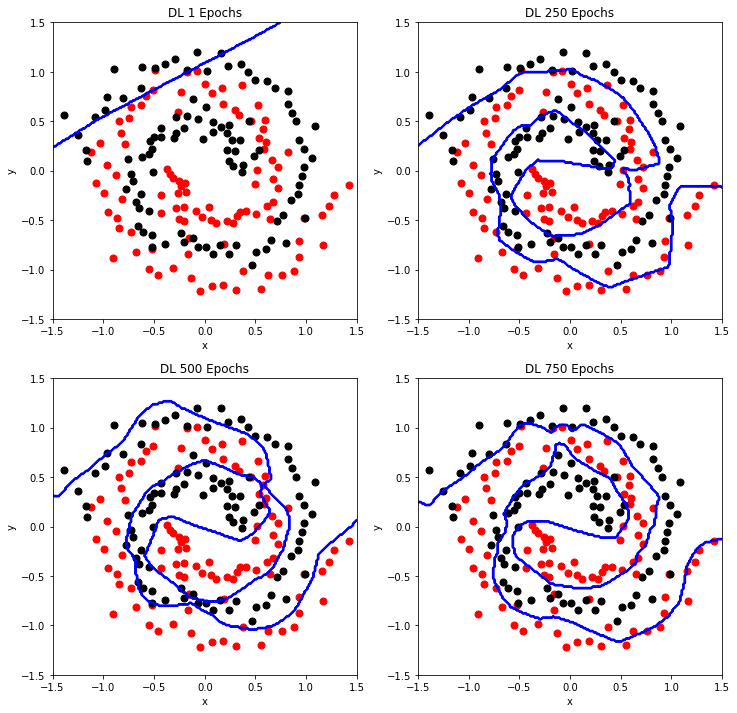

In [29]:
models_dl = [dl_1, dl_250, dl_500, dl_750]
m_names_dl = ["DL " + str(int(model.get_params()['epochs']['actual_value'])) + \
                                     " Epochs" for model in models_dl]

plot_spirals(models_dl, m_names_dl)

### Deep Learning Network Architecture

Of course, there is far more to constructing deep learning models than simply having them run longer.

Consider the four following setups.

  * Single layer, 1000 nodes
  * Two layers, 200 nodes each
  * Three layers, 42 nodes each
  * Four layers, 11 -> 13 -> 17 -> 19
  
The H2O deep learning architecture uses the `hidden` keyword to control model network architecture.
Hidden takes a Python _list_ of integers, representing the number of nodes in each layer.

In [36]:
dl_1 = H2ODeepLearningEstimator(hidden=[1000], epochs=500)
dl_1.train(predictors, label, spiral)

dl_2 = H2ODeepLearningEstimator(hidden=[200,200], epochs=500)
dl_2.train(predictors, label, spiral)

dl_3 = H2ODeepLearningEstimator(hidden=[42,42,42], epochs=500)
dl_3.train(predictors, label, spiral)

dl_4 = H2ODeepLearningEstimator(hidden=[11,13,17,19], epochs = 1000)
dl_4.train(predictors, label, spiral)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


Plot the models to compare the performance.

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


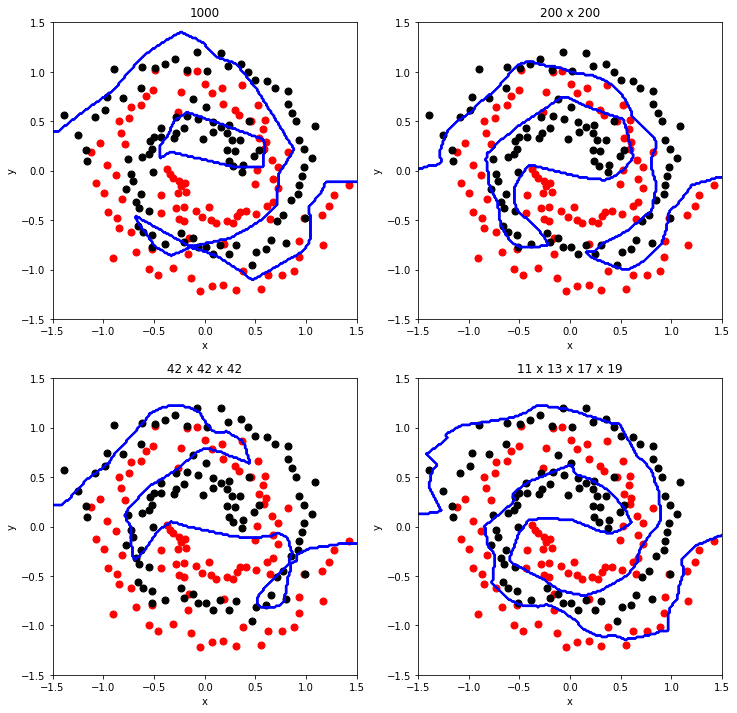

In [37]:
models_network = [dl_1, dl_2, dl_3, dl_4]
m_names_network = ["1000", "200 x 200", "42 x 42 x 42", "11 x 13 x 17 x 19"]

plot_spirals(models_network, m_names_network)

### Activation Functions

Next, compare between different activation functions, including one with 50% dropout regularization in the hidden layers.

I encourage you to read more about the activation functions

  * tanh
  * maxout
  * rectifier
  * rectifier with dropout

In [39]:
models_act = []
m_names_act = []
for i,method in enumerate(["Tanh","Maxout","Rectifier","RectifierWithDropout"]):
    models_act.append(H2ODeepLearningEstimator(activation=method, hidden=[100,100], epochs=1000))
    models_act[i].train(predictors, label, spiral)
    m_names_act.append("DL "+ method + " Activation")

deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


Plot the spirals.

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


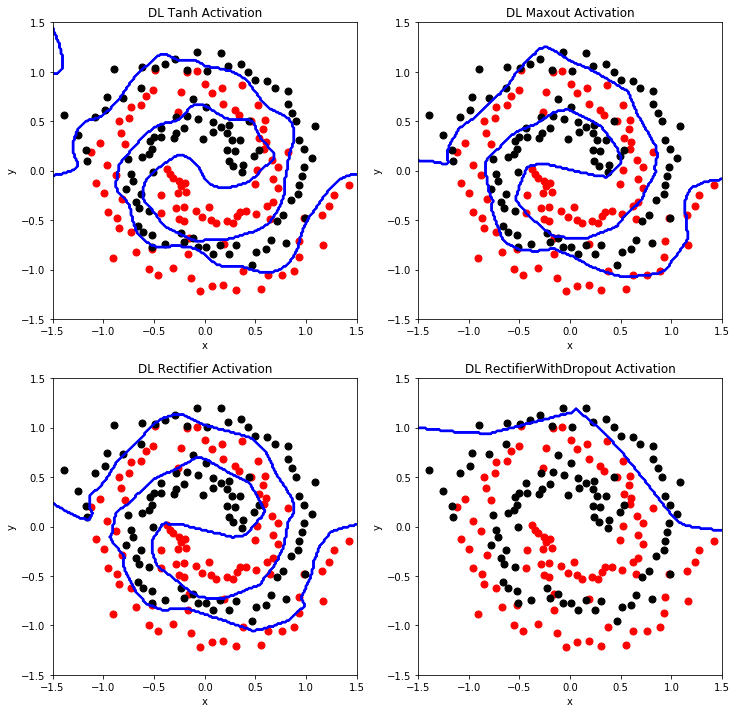

In [40]:
plot_spirals(models_act, m_names_act)

Clearly, the dropout rate was too high or the number of epochs was too low for the last configuration, which often ends up performing the best on larger datasets where generalization is important.

More information about the parameters can be found in the [H2O Deep Learning booklet](http://h2o.ai/resources/).

# Covertype Dataset

The following examples use the covertype dataset from UC Irvine, which concerns predicting forest cover based on cartographical data.  
You will import the full covertype dataset (581k rows, 13 columns, 10 numerical, 3 categorical) and then split the data 3 ways:

60% for training  
20% for validation (hyper parameter tuning)  
20% for final testing

You will train a data set on one set and use the others to test the validity of the model by ensuring that it can predict accurately on data the model has not been shown.

The second set will be used for validation most of the time.

The third set will be withheld until the end, to ensure that your validation accuracy is consistent with data never seen during the iterative process.

In [44]:
covtype_df = h2o.import_file(path = os.path.realpath("../data/covtype.full.csv"))
covtype_df.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
3066,124,5,0,0,1533,229,236,141,459,area_0,type_22,class_1
3136,32,20,450,-38,1290,211,193,111,1112,area_0,type_28,class_1
2655,28,14,42,8,1890,214,209,128,1001,area_2,type_9,class_2
3191,45,19,323,88,3932,221,195,100,2919,area_0,type_39,class_2
3217,80,13,30,1,3901,237,217,109,2859,area_0,type_22,class_7
3119,293,13,30,10,4810,182,237,194,1200,area_0,type_21,class_1
2679,48,7,150,24,1588,223,224,136,6265,area_0,type_11,class_2
3261,322,13,30,5,5701,186,226,180,769,area_0,type_21,class_1
2885,26,9,192,38,3271,216,220,140,2643,area_0,type_28,class_2
3167,271,29,242,37,4700,133,235,234,3260,area_0,type_28,class_1


In [45]:
#split the data as described above
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is cover_type, 
covtype_y = covtype_df.col_names[-1]

## First Impressions

Run your first deep learning model on the covtype dataset.
Predict the `Cover_Type` column, a categorical feature with 7 levels, and the deep learning model will be tasked to perform multi-class classification. It uses the other 12 predictors of the dataset, of which 10 are numerical and 2 are categorical with a total of 44 levels.

You can expect the deep learning model to have 56 input neurons (after automatic one-hot encoding). First run will be only one epoch to get a feel for the model construction.

In [42]:
#set the model_id for easy lookup in H2O Flow
covtype_model_v1 = H2ODeepLearningEstimator(model_id="covtype_v1", epochs=1, variable_importances=True)
covtype_model_v1.train(covtype_X, covtype_y, training_frame = train, validation_frame = valid)

print(covtype_model_v1)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  covtype_v1


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.1319573027095858
RMSE: 0.36325927752720344
LogLoss: 0.4284256052746694
Mean Per-Class Error: 0.3424903288409151
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
2957.0,721.0,0.0,0.0,1.0,1.0,16.0,0.1999459,"739 / 3,696"
467.0,4361.0,33.0,0.0,13.0,21.0,0.0,0.1090909,"534 / 4,895"
0.0,55.0,508.0,16.0,1.0,57.0,0.0,0.2025118,129 / 637
0.0,0.0,10.0,34.0,0.0,4.0,0.0,0.2916667,14 / 48
17.0,102.0,4.0,0.0,33.0,1.0,0.0,0.7898089,124 / 157
2.0,44.0,105.0,4.0,0.0,184.0,0.0,0.4572271,155 / 339
110.0,7.0,0.0,0.0,0.0,0.0,220.0,0.3471810,117 / 337
3553.0,5290.0,660.0,54.0,48.0,268.0,236.0,0.1792462,"1,812 / 10,109"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8207538
2,0.9834801
3,0.9979227
4,0.9997032
5,1.0
6,1.0
7,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.13428517965937523
RMSE: 0.3664494230577737
LogLoss: 0.4334519688711374
Mean Per-Class Error: 0.33385262077683897
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
33971.0,8353.0,1.0,0.0,17.0,9.0,149.0,0.2006824,"8,529 / 42,500"
5635.0,49975.0,344.0,3.0,131.0,269.0,23.0,0.1136041,"6,405 / 56,380"
0.0,573.0,5720.0,175.0,5.0,670.0,0.0,0.1992160,"1,423 / 7,143"
0.0,0.0,117.0,418.0,0.0,27.0,0.0,0.2562278,144 / 562
148.0,1121.0,56.0,0.0,537.0,8.0,0.0,0.7128342,"1,333 / 1,870"
14.0,547.0,1027.0,60.0,6.0,1810.0,0.0,0.4774827,"1,654 / 3,464"
1410.0,135.0,0.0,0.0,0.0,0.0,2554.0,0.3769212,"1,545 / 4,099"
41178.0,60704.0,7265.0,656.0,696.0,2793.0,2726.0,0.1812908,"21,033 / 116,018"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8187092
2,0.9831750
3,0.9982848
4,0.9996035
5,0.9999914
6,1.0
7,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-08-07 21:32:47,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-08-07 21:32:56,13.552 sec,3675 obs/sec,0.1009097,1,35219.0,0.4630506,0.6826440,0.2811356,0.4619598,0.6790120,0.2802324
,2018-08-07 21:33:39,55.799 sec,4341 obs/sec,0.6006619,6,209640.0,0.4025303,0.5211628,0.2188149,0.3994079,0.5129813,0.2134238
,2018-08-07 21:34:16,1 min 32.832 sec,4709 obs/sec,1.0996003,11,383777.0,0.3632593,0.4284256,0.1792462,0.3664494,0.4334520,0.1812908


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Wilderness_Area.area_0,1.0,1.0,0.0313734
Horizontal_Distance_To_Roadways,0.9942958,0.9942958,0.0311944
Elevation,0.9691507,0.9691507,0.0304055
Horizontal_Distance_To_Fire_Points,0.8957474,0.8957474,0.0281026
Wilderness_Area.area_3,0.8469897,0.8469897,0.0265729
---,---,---,---
Vertical_Distance_To_Hydrology,0.4422583,0.4422583,0.0138751
Hillshade_3pm,0.4088742,0.4088742,0.0128278
Aspect,0.2901760,0.2901760,0.0091038
Soil_Type.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



Inspect the model in H2O Flow (usually at `yourIP:54321`) for more information about model building etc.

Enter `getModel "covtype_v1"` into a cell and run in place pressing `Ctrl-Enter`. Alternatively, you can click on the `Models` tab, select `List All Models`, and click on the model named `"covtype_v1"` as specified in your model construction above.

## Variable Importances

Variable importances for Neural Network models are notoriously difficult to compute, and there are many pitfalls. H2O's deep learning has implemented the method of [Gedeon](http://cs.anu.edu.au/~./Tom.Gedeon/pdfs/ContribDataMinv2.pdf), and returns relative variable importances in descending order of importance.

Note that you have exactly 56 input neurons, as expected.

In [47]:
var_df = pd.DataFrame(covtype_model_v1.varimp(), 
             columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
print(var_df.shape)
var_df.head(10)

(56, 4)


,Variable,Relative Importance,Scaled Importance,Percentage
0,Wilderness_Area.area_0,1.000000,1.000000,0.031373
1,Horizontal_Distance_To_Roadways,0.994296,0.994296,0.031194
2,Elevation,0.969151,0.969151,0.030406
3,Horizontal_Distance_To_Fire_Points,0.895747,0.895747,0.028103
4,Wilderness_Area.area_3,0.846990,0.846990,0.026573
5,Wilderness_Area.area_2,0.767919,0.767919,0.024092
6,Soil_Type.type_31,0.725202,0.725202,0.022752
7,Soil_Type.type_32,0.705238,0.705238,0.022126
8,Soil_Type.type_23,0.679684,0.679684,0.021324
9,Soil_Type.type_28,0.676321,0.676321,0.021218


## Early Stopping

Now run another, smaller network and let it stop automatically once the misclassification rate converges (specifically if the moving average of length 2 does not improve by at least 1% for two consecutive scoring events).

Also sample the validation set to 10,000 rows for faster scoring.

In [48]:
covtype_model_v2 = H2ODeepLearningEstimator(
    model_id="covtype_v2", 
    hidden=[32,32,32],                  ## small network, runs faster
    epochs=1000000,                      ## hopefully converges earlier...
    score_validation_samples=10000,      ## sample the validation dataset (faster)
    stopping_rounds=2,
    stopping_metric="misclassification", ## alternatives: "MSE","logloss","r2"
    stopping_tolerance=0.01)
covtype_model_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


To look at the scoring history, you could look up your new model in Flow. Alternatively, you can use the `score_history` method to retrieve the data as a pandas `DataFrame`.

In [49]:
cov_v2_df = covtype_model_v2.score_history()
cov_v2_df

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2018-08-07 21:41:44,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-08-07 21:41:46,2.359 sec,46649 obs/sec,0.287237,1,100250.0,0.469935,0.702070,0.301507,0.471560,0.696459,0.302196
2,,2018-08-07 21:41:52,8.378 sec,49584 obs/sec,1.147504,4,400496.0,0.394586,0.492405,0.205727,0.393625,0.487786,0.202295
3,,2018-08-07 21:41:58,14.724 sec,48883 obs/sec,2.008756,7,701086.0,0.377984,0.458759,0.188866,0.377061,0.450625,0.193513
4,,2018-08-07 21:42:04,20.623 sec,49722 obs/sec,2.870395,10,1001811.0,0.364410,0.430893,0.179986,0.366051,0.429538,0.179242
5,,2018-08-07 21:42:10,26.298 sec,50598 obs/sec,3.730648,13,1302052.0,0.360473,0.420968,0.173700,0.366682,0.432462,0.183034
6,,2018-08-07 21:42:16,31.962 sec,51205 obs/sec,4.591020,16,1602335.0,0.358889,0.417543,0.176993,0.360188,0.418883,0.177745
7,,2018-08-07 21:42:21,37.539 sec,51721 obs/sec,5.450826,19,1902420.0,0.355283,0.407322,0.169710,0.354781,0.406056,0.166866
8,,2018-08-07 21:42:27,43.654 sec,51436 obs/sec,6.309672,22,2202170.0,0.349755,0.403986,0.160431,0.351846,0.405005,0.165469
9,,2018-08-07 21:42:33,49.498 sec,51524 obs/sec,7.171293,25,2502889.0,0.344472,0.390271,0.160231,0.342372,0.383505,0.157784


Plot the scoring history.

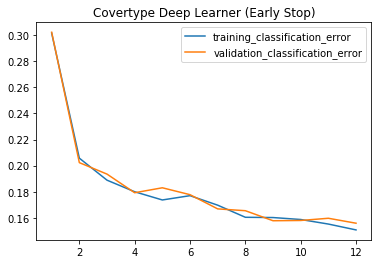

In [51]:
plt.plot(cov_v2_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_v2_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Early Stop)")
plt.legend();

## Adaptive Learning Rate

By default, H2O deep learning uses an adaptive learning rate ([ADADELTA](http://arxiv.org/pdf/1212.5701v1.pdf)) for its stochastic gradient descent optimization. There are only two tuning parameters for this method: `rho` and `epsilon`, which balance the global and local search efficiencies. `rho` is the similarity to prior weight updates (similar to momentum), and `epsilon` is a parameter that prevents the optimization from getting stuck in local optima.

Defaults are `rho=0.99` and `epsilon=1e-8`. For cases where convergence speed is very important, it might make sense to perform a few runs to optimize these two parameters (e.g., with `rho in [0.9, 0.95, 0.99, 0.999]` and `epsilon in [1e-10, 1e-8, 1e-6, 1e-4]`). Of course, as always with grid searches, caution has to be applied when extrapolating grid search results to a different parameter regime (e.g., for more epochs, different layer topologies or activation functions, etc).

If `adaptive_rate` is disabled, several manual learning rate parameters become important: `rate`, `rate_annealing`, `rate_decay`,  `momentum_start`, `momentum_ramp`, `momentum_stable` and `nesterov_accelerated_gradient`; you can find more information in the [H2O deep learning booklet](http://h2o.ai/resources/).

## Tuning

With some tuning, it is possible to obtain less than 10% test set error rate in about one minute. Error rates of below 5% are possible with larger models. Deep-tree methods are more effective for this dataset than deep learning, as the space needs to be simply be partitioned into the corresponding hyper-space corners to solve this problem.

In [52]:
covtype_model_tuned = H2ODeepLearningEstimator(
  model_id="covtype_tuned",
  overwrite_with_best_model=False,
  hidden=[128,128,128],            # more hidden layers -> more complex interactions
  epochs=10,                       # to keep it short enough
  score_validation_samples=10000,  # downsample validation set for faster scoring
  score_duty_cycle=0.025,          # don't score more than 2.5% of the wall time
  adaptive_rate=False,             # manually tuned learning rate
  rate=0.01, 
  rate_annealing=0.000002,            
  momentum_start=0.2,              # manually tuned momentum
  momentum_stable=0.4, 
  momentum_ramp=10000000, 
  l1=0.00001,                      # add some L1/L2 regularization
  l2=0.00001,
  max_w2=10.                       # helps stability for Rectifier
)
covtype_model_tuned.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Compare the training error with the validation and test set errors.

In [53]:
cov_tuned_df = covtype_model_tuned.scoring_history()
cov_tuned_df

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2018-08-07 21:50:41,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-08-07 21:50:50,10.101 sec,10632 obs/sec,0.283263,1,98863.0,0.420643,0.547897,0.234495,0.424603,0.555424,0.237676
2,,2018-08-07 21:51:23,42.178 sec,12038 obs/sec,1.412169,5,492868.0,0.348228,0.386390,0.161790,0.352286,0.394833,0.164584
3,,2018-08-07 21:51:45,1 min 4.419 sec,12565 obs/sec,2.260725,8,789027.0,0.317372,0.322100,0.138820,0.323684,0.336896,0.139286
4,,2018-08-07 21:52:06,1 min 25.812 sec,12944 obs/sec,3.107336,11,1084507.0,0.297790,0.286568,0.116748,0.307937,0.308911,0.124788
5,,2018-08-07 21:52:28,1 min 47.214 sec,13179 obs/sec,3.954331,14,1380121.0,0.286682,0.267705,0.110956,0.297648,0.289198,0.117888
6,,2018-08-07 21:52:49,2 min 8.303 sec,13357 obs/sec,4.799358,17,1675048.0,0.271458,0.243013,0.100669,0.285582,0.268997,0.107889
7,,2018-08-07 21:53:10,2 min 29.505 sec,13471 obs/sec,5.644116,20,1969881.0,0.263333,0.227247,0.095376,0.277080,0.253506,0.101690
8,,2018-08-07 21:53:31,2 min 51.086 sec,13530 obs/sec,6.490328,23,2265222.0,0.258458,0.219575,0.088085,0.272661,0.246352,0.096690
9,,2018-08-07 21:53:47,3 min 7.083 sec,13455 obs/sec,7.055553,25,2462494.0,0.252858,0.212748,0.087586,0.266110,0.238315,0.093191


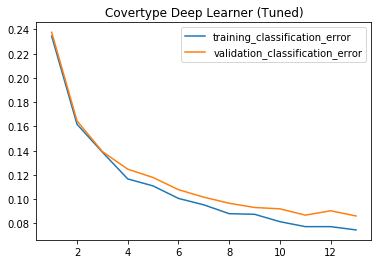

In [54]:
plt.plot(cov_tuned_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_tuned_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Tuned)")
plt.legend();

In [55]:
pred = covtype_model_tuned.predict(test[0:-1]).as_data_frame(use_pandas=True)
test_actual = test.as_data_frame(use_pandas=True)['Cover_Type']
(test_actual == pred['predict']).mean()

deeplearning prediction progress: |███████████████████████████████████████| 100%


0.91712292742651691

Compare with the early stopping model.

In [56]:
pred0 = covtype_model_v2.predict(test[0:-1]).as_data_frame(use_pandas=True)
(test_actual == pred0['predict']).mean()

deeplearning prediction progress: |███████████████████████████████████████| 100%


0.84596349339104493

In [57]:
h2o.save_model(covtype_model_tuned)

'/Users/jamespearce/repos/dl/notebooks/covtype_tuned'

In [58]:
h2o.cluster().shutdown()

H2O session _sid_8623 closed.
